In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transformers
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import sklearn
from sklearn.preprocessing import normalize
from tqdm import tqdm

import glob
import time

import math
import os
from sklearn.model_selection import train_test_split

In [2]:
initial_states = []

path = "input_data/"

for dir, sub_dir, files in os.walk(path):
    for file in sorted(files):
        #print(file)
        temp = pd.read_csv((path+file),index_col=None, header=0)
        initial_states.append(temp)

initial_states_df = pd.concat(initial_states,axis=0,ignore_index=True)

hold = initial_states_df
x = initial_states_df.iloc[:,2:].values
x = normalize(x,norm='l2')
hold = pd.concat([hold['File ID'],pd.DataFrame(x)],axis=1)
initial_states_normalized = hold
#'2000-08-02 04:50:33'
timestamps = initial_states_df['Timestamp']
#initial_states_df

In [3]:
class FullDatasetPT(Dataset):
    def __init__(self, initial_states_df, pt_dir='data/processed/pt_files'):
        self.data = initial_states_df.reset_index(drop=True)
        self.pt_dir = pt_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        file_id = str(int(row['File ID'])).zfill(5)
        pt_path = os.path.join(self.pt_dir, f"{file_id}.pt")

        if not os.path.exists(pt_path):
            raise FileNotFoundError(f".pt file not found for File ID: {file_id}")

        static_input = torch.tensor(row.drop("File ID").fillna(0.0).values, dtype=torch.float32)
        pt_data = torch.load(pt_path)

        return (
            static_input,
            pt_data["density"],
            pt_data["density_mask"],
            pt_data["goes"],
            pt_data["goes_mask"],
            pt_data["omni2"],
            pt_data["omni2_mask"]
        )



In [4]:
# -----------------------------------
# Positional Encoding for Sequences
# -----------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4320):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2) * math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

# -----------------------------------
# STORMTransformer with Feature Mask Concatenation (No Downsampling)
# -----------------------------------
class STORMTransformer(nn.Module):
    def __init__(self,
                 static_dim=9,
                 omni2_dim=57,
                 goes_dim=42,
                 d_model=128,
                 output_len=432,
                 nhead=8,
                 num_layers=4,
                 dropout=0.1):
        super().__init__()

        self.static_encoder = nn.Sequential(
            nn.Linear(static_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model)
        )

        # Inputs are doubled due to feature-mask concatenation
        self.omni2_proj = nn.Linear(omni2_dim * 2, d_model)
        self.goes_proj = nn.Linear(goes_dim * 2, d_model)

        self.omni2_pos = PositionalEncoding(d_model)
        self.goes_pos = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.omni2_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.goes_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # self.fusion = nn.Sequential(
        #     nn.Linear(d_model * 3, 256),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(256, output_len)
        # )
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 3, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256,360),
            nn.BatchNorm1d(360),
            nn.ReLU(),
            nn.Linear(360, output_len)
        )

    def forward(self, static_input, omni2_seq, goes_seq, omni2_mask=None, goes_mask=None):
        B = static_input.size(0)

        # ----- Static Embedding -----
        static_embed = self.static_encoder(static_input)

        # ----- OMNI2 -----
        if omni2_mask is not None:
            omni2_cat = torch.cat([omni2_seq, omni2_mask], dim=-1)  # [B, T, 2D]
        else:
            omni2_cat = omni2_seq
        omni2_embed = self.omni2_proj(omni2_cat)
        omni2_embed = self.omni2_pos(omni2_embed)
        omni2_out = self.omni2_encoder(omni2_embed)  # ⬅️ No key mask
        omni2_summary = omni2_out.mean(dim=1)

        # ----- GOES Downsampling to 8640 -----
        if goes_seq.shape[1] > 4320:
            step = goes_seq.shape[1] // 4320
            goes_seq = goes_seq[:, ::step, :]
            goes_mask = goes_mask[:, ::step, :] if goes_mask is not None else None

        if goes_mask is not None:
            goes_cat = torch.cat([goes_seq, goes_mask], dim=-1)  # [B, T, 2D]
        else:
            goes_cat = goes_seq
        goes_embed = self.goes_proj(goes_cat)
        goes_embed = self.goes_pos(goes_embed)
        goes_out = self.goes_encoder(goes_embed)  # ⬅️ No key mask
        goes_summary = goes_out.mean(dim=1)

        # ----- Fusion -----
        combined = torch.cat((static_embed, omni2_summary, goes_summary), dim=-1)
        return self.fusion(combined)

# -----------------------------------
# Masked MSE Loss
# -----------------------------------
def masked_mse_loss(preds, targets, mask, eps=1e-8):
    # preds = torch.nan_to_num(preds, nan=0.0, posinf=1e3, neginf=0.0)
    # targets = torch.nan_to_num(targets, nan=0.0, posinf=1e3, neginf=0.0)
    # loss = (preds - targets) ** 2 * mask
    # return loss.sum() / (mask.sum() + eps)
    diff = (targets - preds) * mask
    sq = torch.square(diff)
    sum = torch.sum(sq)
    N = torch.sum(mask)
    # print(sum)
    # print(N)
    loss = torch.sqrt((sum/N))
    return loss

# -----------------------------------
# Full Training Loop with FullDataset
# -----------------------------------

train_loss_history = []
val_loss_history = []

In [16]:
def train_storm_transformer(initial_states_df, num_epochs=100, batch_size=16, lr=1e-4, device=None):
    # from full_dataset import FullDataset
    # from storm_transformer import STORMTransformer, masked_mse_loss

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs("checkpoints", exist_ok=True)

    torch.manual_seed(42)

    # 🔀 Train/validation split
    train_df, val_df = train_test_split(initial_states_df[0:8112], test_size=0.05, random_state=42)

    train_dataset = FullDatasetPT(train_df)
    val_dataset = FullDatasetPT(val_df)

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, )
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


    model = STORMTransformer().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    checkpoint_path = "checkpoints/storm_last.pt"
    best_model_path = "checkpoints/storm_best.pt"
    start_epoch = 0
    best_val_loss = float("inf")

    # 🔁 Resume support
    if os.path.exists(checkpoint_path):
        print(f"🔁 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0)
        best_val_loss = checkpoint.get('val_loss', float("inf"))

    # 🚀 Training loop
    
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0.0

        print(f"\n🚀 Epoch {epoch + 1}/{num_epochs}")
        #start_load = time.time()
        for batch in tqdm(train_loader):
            static_input, density, density_mask, goes, goes_mask, omni2, omni2_mask = batch
            #nd_load = time.time()

            static_input = static_input.to(device)
            density = density.to(device)
            density_mask = density_mask.to(device)
            goes = goes.to(device)
            goes_mask = goes_mask.to(device)
            omni2 = omni2.to(device)
            omni2_mask = omni2_mask.to(device)

            # if (omni2_mask.any(dim=-1).sum(dim=1) == 0).any() or (goes_mask.any(dim=-1).sum(dim=1) == 0).any():
            #     print("⚠️ Skipping batch with fully masked inputs")
            #     continue

            optimizer.zero_grad()
            preds = model(static_input, omni2, goes, omni2_mask, goes_mask)
            # print ("Preds:", preds)
            # print ("Targets",density)
            #print (preds)
            loss = masked_mse_loss(preds, density, density_mask)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

            #end_batch = time.time()

            # print ("Load time:", end_load - start_load )
            # print ("Calc time:", end_batch - end_load)

        avg_train_loss = total_train_loss / len(train_loader)
        print ("Preds:", preds)
        print ("Targets",density)

        # 🧪 Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                static_input, density, density_mask, goes, goes_mask, omni2, omni2_mask = batch

                static_input = static_input.to(device)
                density = density.to(device)
                density_mask = density_mask.to(device)
                goes = goes.to(device)
                goes_mask = goes_mask.to(device)
                omni2 = omni2.to(device)
                omni2_mask = omni2_mask.to(device)

                if (omni2_mask.any(dim=-1).sum(dim=1) == 0).any() or (goes_mask.any(dim=-1).sum(dim=1) == 0).any():
                    continue

                preds = model(static_input, omni2, goes, omni2_mask, goes_mask)
                loss = masked_mse_loss(preds, density, density_mask)
                #print ("loss",loss,"-------------------")
                total_val_loss += loss.item()

                # 🧠 Mask diagnostics
                goes_mask_sum = goes_mask.sum().item()
                omni2_mask_sum = omni2_mask.sum().item()
                density_mask_sum = density_mask.sum().item()

                print(f"🧪 Eval Batch {batch_idx+1}/{len(val_loader)} — "
                      f"OMNI2 Mask Sum: {omni2_mask_sum} | "
                      f"GOES Mask Sum: {goes_mask_sum} | "
                      f"Density Mask Sum: {density_mask_sum}")

                # ⚠️ Alert if any mask has < 10% coverage
                if omni2_mask_sum < 0.1 * omni2_mask.numel():
                    print("⚠️ Low OMNI2 coverage in this batch!")
                if goes_mask_sum < 0.1 * goes_mask.numel():
                    print("⚠️ Low GOES coverage in this batch!")
                if density_mask_sum < 0.1 * density_mask.numel():
                    print("⚠️ Low density mask coverage in this batch!")

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"\n📊 Epoch {epoch+1}/{num_epochs} — "
              f"Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss}")
        
        print ("Preds:", preds)
        print ("Targets",density)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        # 💾 Save full checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss
        }, checkpoint_path)

        # 💎 Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"checkpoints/epoch{epoch}.pt")
            print("✅ Best model updated.")


In [17]:
train_storm_transformer(initial_states_normalized)

🔁 Resuming from checkpoint: checkpoints/storm_last.pt

🚀 Epoch 49/100


100%|██████████| 482/482 [09:53<00:00,  1.23s/it]

Preds: tensor([[ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04],
        [ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04],
        [ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04],
        ...,
        [ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04],
        [ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04],
        [ 2.3265e-06, -5.3633e-09, -1.6582e-08,  ..., -3.3427e-07,
         -1.4046e-04, -1.0738e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)
Targets tensor([[2.5025e-12, 2.4971e-12, 2.4794e-12,  ..., 2.2223e-12, 2.2103e-12,
         2.1908e-12],
        [2.5089e-13, 2.4738e-13, 2.3532e-13,  ..., 1.5317e-13, 1.5665e-13,
         1.6073e-13],
        [3.9850e-14, 3.9678e-14, 3.9931e-14,  ..., 4.1768e-14, 4.1275e-14,
         4.0817e-14],
        ...,
      

🧪 Eval Batch 26/26 — OMNI2 Mask Sum: 492480.0 | GOES Mask Sum: 2937816.0 | Density Mask Sum: 2592.0

📊 Epoch 49/100 — Train Loss: 0.002417708924368673 | Val Loss: 6.043646359243072e-05
Preds: tensor([[ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05],
        [ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05],
        [ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05],
        [ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05],
        [ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05],
        [ 1.9414e-07,  3.5270e-08,  1.1203e-08,  ...,  3.4790e-07,
          1.8851e-04, -2.8156e-05]], device='cuda:0')
Targets tensor([[4.4862e-14, 4.4614e-14, 4.4473e-14,  ..., 4.3594e-14, 4.3997e-14,
         4.4936e-14],
        [2.5604e-13, 2.5200e-13, 2.4636e-13,  ..., 1.3770e-13, 1.46

100%|██████████| 482/482 [09:51<00:00,  1.23s/it]

Preds: tensor([[ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05],
        [ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05],
        [ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05],
        ...,
        [ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05],
        [ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05],
        [ 1.8771e-04, -1.0736e-07,  9.2092e-06,  ...,  5.6571e-04,
         -2.6376e-07,  3.1027e-05]], device='cuda:0', grad_fn=<AddmmBackward0>)
Targets tensor([[1.1246e-12, 1.1225e-12, 1.1291e-12,  ..., 1.3210e-12, 1.3197e-12,
         1.3094e-12],
        [2.9357e-12, 2.9342e-12, 2.9368e-12,  ..., 3.8434e-12, 3.8283e-12,
         3.8272e-12],
        [7.3486e-14, 7.3367e-14, 7.2901e-14,  ..., 6.5407e-14, 6.5757e-14,
         6.5433e-14],
        ...,
      

🧪 Eval Batch 26/26 — OMNI2 Mask Sum: 492480.0 | GOES Mask Sum: 2937816.0 | Density Mask Sum: 2592.0

📊 Epoch 50/100 — Train Loss: 0.0019986364433514842 | Val Loss: 7.209267306069915e-05
Preds: tensor([[-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04],
        [-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04],
        [-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04],
        [-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04],
        [-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04],
        [-2.8804e-04,  9.1942e-08, -1.1362e-05,  ..., -5.8239e-04,
          2.0854e-07, -1.0114e-04]], device='cuda:0')
Targets tensor([[4.4862e-14, 4.4614e-14, 4.4473e-14,  ..., 4.3594e-14, 4.3997e-14,
         4.4936e-14],
        [2.5604e-13, 2.5200e-13, 2.4636e-13,  ..., 1.3770e-13, 1.4

100%|██████████| 482/482 [09:53<00:00,  1.23s/it]

Preds: tensor([[ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07],
        [ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07],
        [ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07],
        ...,
        [ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07],
        [ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07],
        [ 1.9683e-03, -1.0872e-11,  4.8848e-04,  ...,  5.8848e-07,
         -1.3799e-11,  1.4515e-07]], device='cuda:0', grad_fn=<AddmmBackward0>)
Targets tensor([[1.6811e-12, 1.6908e-12, 1.6995e-12,  ..., 1.8781e-12, 1.8642e-12,
         1.8620e-12],
        [0.0000e+00, 0.0000e+00, 1.1128e-13,  ..., 9.3501e-14, 9.3720e-14,
         9.3006e-14],
        [1.9912e-13, 1.9735e-13, 2.0074e-13,  ..., 3.5839e-13, 3.6086e-13,
         3.6130e-13],
        ...,
      

🧪 Eval Batch 26/26 — OMNI2 Mask Sum: 492480.0 | GOES Mask Sum: 2937816.0 | Density Mask Sum: 2592.0

📊 Epoch 51/100 — Train Loss: 0.0021143126994887314 | Val Loss: 0.00010808909204430305
Preds: tensor([[-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07],
        [-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07],
        [-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07],
        [-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07],
        [-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07],
        [-1.3614e-03, -2.9666e-11, -1.3412e-05,  ..., -2.1639e-06,
          1.1848e-11, -1.4201e-07]], device='cuda:0')
Targets tensor([[4.4862e-14, 4.4614e-14, 4.4473e-14,  ..., 4.3594e-14, 4.3997e-14,
         4.4936e-14],
        [2.5604e-13, 2.5200e-13, 2.4636e-13,  ..., 1.3770e-13, 1.

 11%|█         | 53/482 [01:15<10:07,  1.42s/it] 
Exception in thread Thread-125 (_pin_memory_loop):
Traceback (most recent call last):
  File "/root/miniconda3/envs/runpod_conda/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/envs/runpod_conda/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/root/miniconda3/envs/runpod_conda/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/root/miniconda3/envs/runpod_conda/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/root/miniconda3/envs/runpod_conda/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/miniconda3/envs/runpod_conda/lib/pyt

KeyboardInterrupt: 

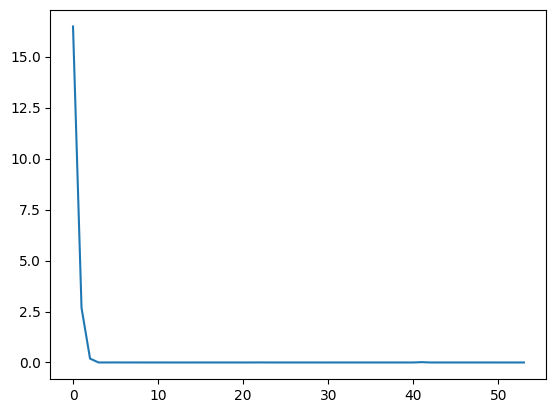

In [18]:
plt.plot(val_loss_history)